In [150]:
#Download dahulu library
%pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [151]:
#inisiasi library

from yellowbrick.datasets import load_hobbies
from sklearn.preprocessing import LabelEncoder
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import re

# Load the Yellowbrick hobbies dataset
corpus = load_hobbies()

# Separate the features (paragraphs or sentences) and labels
posts = corpus.data
labels = corpus.target

print(posts)
print(len(posts))
print(labels)
print(len(labels))

["\n\nFrom \n\n to \n\n, Oscar voters can't get enough of book adaptations. Nowhere is this trend more obvious than in the Best Actor and Best Actress categories.\n\n\n\nYes, movies have been based on books and true stories since the silent film era, but this year represents a notable spike: While true story adaptations remain relatively flat, the number of best actor or actress nominees who starred in movies based on books have reached a new peak this year.\n\n\n\nAn even bigger indicator? Movies in which book and true story adaptation overlap. That has been a clear path to Oscar glory in the Best Actor category.\n\n\n\nAll of this year's Best Actor nominees are from movies based on books \n\n true stories, except for one: Matt Damon's turn as a stranded astronaut in the science fiction thriller \n\n.\n\n\n\nHowever, Oscar voters don't seem to favor true stories as much in the Best Actress category. While two out of the past three Best Actress winners have been from films based on boo

In [152]:
#Some function
def clean_sentences(data):
    #list all stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    articles = []
    #process each article in corpus
    for article in data:
        #convert to string
        article = ''.join(article)
        # Sentence converted to lowercase-only
        sentences = article.lower()
        # Remove non-word characters (excluding punctuation marks)
        sentences = re.sub(r"[^\w\s\.,!?']", " ", sentences)

        # Remove excessive whitespaces
        sentences = re.sub(r"\s+", " ", sentences).strip()

        # split per words
        words = sentences.split(" ")
        #remove stopwords
        no_words = [w for w in words if w not in stopwords]
        sentences = " ".join(no_words)
        # Remove multispaces
        sentences = sentences.replace("  ", " ")
        articles.append(sentences)
    return articles


In [153]:
#Preprocessing
#clean sentences from stopwords, etc.
posts = clean_sentences(posts)
print (posts[0])

, oscar voters can't get enough book adaptations. nowhere trend obvious best actor best actress categories. yes, movies based books true stories since silent film era, year represents notable spike true story adaptations remain relatively flat, number best actor actress nominees starred movies based books reached new peak year. even bigger indicator? movies book true story adaptation overlap. clear path oscar glory best actor category. year's best actor nominees movies based books true stories, except one matt damon's turn stranded astronaut science fiction thriller . however, oscar voters don't seem favor true stories much best actress category. two past three best actress winners films based books julianne moore jennifer lawrence , go back 2011 find true story adaptation taking home award. get back year. nine book film adaptations nominated best actor best actress oscar fall two distinct groups based blockbuster book based book people never heard let alone read . book popularity isn'

In [154]:
# Perform stratified train-test split
train_posts, test_posts, train_labels, test_labels = train_test_split(posts, labels, test_size=0.2, stratify=labels, random_state=42)

# Check the distribution of labels in the train and test sets
train_label_counts = {label: train_labels.count(label) for label in set(train_labels)}
test_label_counts = {label: test_labels.count(label) for label in set(test_labels)}

# Print the label distribution in train and test sets
print("Train set label distribution:")
print(train_label_counts)
print(train_posts)
print("Test set label distribution:")
print(test_label_counts)
print(test_posts)


Train set label distribution:
{'sports': 94, 'books': 58, 'gaming': 102, 'cinema': 80, 'cooking': 24}
['ever wonder favorite chefs make food taste look good? tune weekend food network chefs reveal secrets kitchen, time working restaurants more. first saturday, ree drummond answering fans asked questions makes mexican chicken soup white sandwich bread scratch. then, co hosts kitchen spilling secrets restaurants use make food taste delicious, making potato chip crusted salmon pickle brined pork chop. sunday morning, nancy fuller celebrating farmhouse s 250 year anniversary spread including beans greens bruschetta bacon wrapped pork roast. sunday night, guy fieri challenging four chefs grocery games redemption tournament, one can move finale compete 20,000. that, spring bakers taking outdoor theme ballpark snack desserts alton brown hosting special breakfast episode cutthroat kitchen. pioneer woman faq ree hosts pioneer woman q answers include stunning slow cooker mexican chicken soup hea

In [155]:
# Reusing the previous code
# Mapping the strings into integer
label_map = {'sports': 0, 'cinema': 1, 'books': 2, 'gaming': 3, 'cooking': 4}
train_labels = [label_map[label] for label in train_labels]
train_label_counts = {label: train_labels.count(label) for label in set(train_labels)}

# Defining class weight for the model to balance the dataset
total = len(train_labels) # This is 358
class_weights = {}
for i in range(5):
    class_weights[i] = total / (5 * train_label_counts[i]) # This is the inverse frequency formula


In [156]:
#Function to set the train_size and batch_size
train_size = len(train_labels)
batch_size = 16 # This is your choice
epochs = 100 # This is your choice
steps_per_epoch = train_size // batch_size # This is 358 / 16 = 22
decay_steps = steps_per_epoch * epochs # This is 22 * 10 = 220


In [157]:
# Convert labels to numeric form
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.fit_transform(test_labels)

# Tokenize and pad the sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_posts)
train_sequences = tokenizer.texts_to_sequences(train_posts)
test_sequences = tokenizer.texts_to_sequences(test_posts)

max_seq_length = 5000
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    train_sequences, maxlen=max_seq_length, padding='post'
)
test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    test_sequences, maxlen=max_seq_length, padding='post'
)

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) +1, output_dim=100, input_length=max_seq_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    ##tf.keras.layers.Dense(len(set(train_labels_encoded)), activation='softmax')
    tf.keras.layers.Dense(5, activation='softmax')
])

In [158]:
# Some optimization, learning rate decay, and solving the imbalanced data
#Optimization

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.007,
    decay_steps=decay_steps,
    decay_rate=0.95
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [159]:
# Compile the model
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_sequences_padded, train_labels_encoded, 
                    epochs=epochs, batch_size=batch_size, verbose=1, 
                    class_weight=class_weights,
                    validation_data=(test_sequences_padded, test_labels_encoded))

Epoch 1/100
23/23 [==============================] - 1s 22ms/step - loss: 1.6185 - accuracy: 0.2151 - val_loss: 1.6098 - val_accuracy: 0.1556
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 1.6110 - accuracy: 0.1173 - val_loss: 1.5956 - val_accuracy: 0.2667
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 1.6115 - accuracy: 0.1173 - val_loss: 1.6074 - val_accuracy: 0.2667
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 1.6082 - accuracy: 0.1229 - val_loss: 1.6116 - val_accuracy: 0.1444
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 1.5994 - accuracy: 0.2291 - val_loss: 1.6149 - val_accuracy: 0.2444
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 1.6018 - accuracy: 0.2542 - val_loss: 1.6130 - val_accuracy: 0.1444
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 1.5954 - accuracy: 0.2095 - val_loss: 1.6146 - val_accuracy: 0.1556
Epoch 8/100


In [160]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

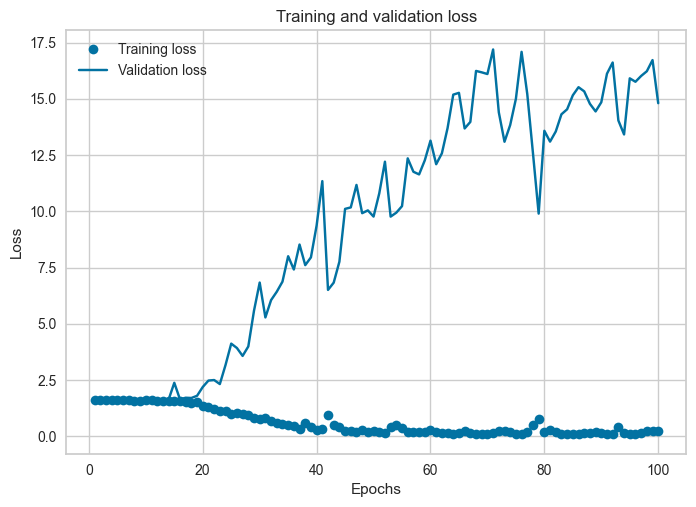

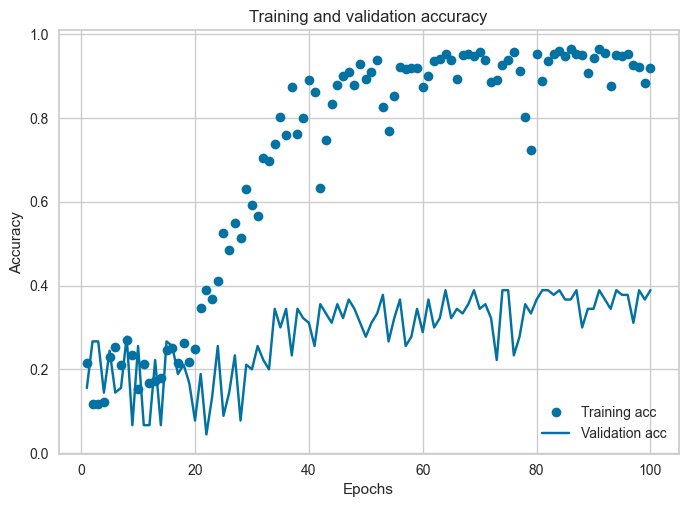

In [161]:
#evaluation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#plot Training vs Validation Loss
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
#plot Training vs Validation Accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [162]:
# Example sentences for prediction
ex_sentences = [["How to cook fried chicken easily"]]
#ex_sentences = [
#    "paris can land sweet side, like lemon tarts lean toward tart tangy, just touch sugar balance juicy acidity lemons",
#    "Oscar voters can't get enough of book adaptations",
#    "How to cook fried chicken easily"
#]

# Preprocess the sentences for prediction
ex_sentence_sequences = tokenizer.texts_to_sequences(ex_sentences)
ex_sentence_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    ex_sentence_sequences, maxlen=max_seq_length
)

# Make predictions on the example sentences
predictions = model.predict(ex_sentence_sequences_padded)
predictions_labels = np.argmax(predictions, axis=1)
print(len(predictions_labels))
#predicted_labels_encoded = predictions.argmax(axis=1)
#predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)
print(predictions_labels)
#Map predicted label
label_mapping = {0: 'Books', 1: 'Cinema', 2: 'Cooking', 3: 'Sports', 4: 'Gaming'}
labels = (label_mapping[predictions_label] for predictions_label in predictions_labels)

# Print the predicted labels for each sentence
for ex_sentence, label in zip(ex_sentences, labels):
    print("Sentence: ", ex_sentence)
    print("Predicted Label: ", label)
    print()


1/1 [==============================] - 0s 42ms/step
1
[2]
Sentence:  ['How to cook fried chicken easily']
Predicted Label:  Cooking



In [163]:
sentences = [
    ["Cristiano Ronaldo's unrivaled soccer techniques serve as an inspiration to countless players around the globe."], 
["This article provides a glimpse into the extraordinary skill set and mindset that have propelled him to the pinnacle of the sport."],
["By studying and implementing the insights gained from Ronaldo's techniques, aspiring players can take significant strides toward mastering their own soccer abilities, bringing them closer to their goals on the field."]
]

# Preprocess the sentences for prediction
sentence_sequences = tokenizer.texts_to_sequences(sentences)
sentence_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(sentence_sequences, maxlen=max_seq_length)

# Make predictions on the example sentences
predictions = model.predict(sentence_sequences_padded)
print (predictions)
# Decode the predicted labels
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Print the predicted labels for each sentence
for sentence, label in zip(sentences, predicted_labels):
    print(f"Sentence: {sentence}")
    print(f"Predicted Label: {label}")
    print()

1/1 [==============================] - 0s 15ms/step
[[0.07019216 0.04615188 0.49782258 0.3344497  0.0513836 ]
 [0.07019216 0.04615188 0.49782258 0.3344497  0.0513836 ]
 [0.07019216 0.04615188 0.49782258 0.3344497  0.0513836 ]]
Sentence: ["Cristiano Ronaldo's unrivaled soccer techniques serve as an inspiration to countless players around the globe."]
Predicted Label: cooking

Sentence: ['This article provides a glimpse into the extraordinary skill set and mindset that have propelled him to the pinnacle of the sport.']
Predicted Label: cooking

Sentence: ["By studying and implementing the insights gained from Ronaldo's techniques, aspiring players can take significant strides toward mastering their own soccer abilities, bringing them closer to their goals on the field."]
Predicted Label: cooking

